In [1]:
%matplotlib inline
from datetime import datetime
import time, re, os
import pandas as pd
import numpy as np
from nltk.stem.porter import *
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
from nltk.corpus import stopwords
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

/home/natanael/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
filename='model_saved.h5'

seed = 7
np.random.seed(seed)

epochs = 5

# dimensionalidade do word embedding pré-treinado
word_embedding_dim = 50

# número de amostras a serem utilizadas em cada atualização do gradiente
batch_size = 32

# Reflete a quantidade máxima de palavras que iremos manter no vocabulário
max_fatures = 5000

# dimensão de saída da camada Embedding
embed_dim = 128

# limitamos o tamanho máximo de todas as sentenças
max_sequence_length = 300

pre_trained_wv = False

bilstm = False

In [3]:
df = pd.read_csv('tweets_eleicao_2018.csv', delimiter=',')

In [4]:
df.head(5)

,Unnamed: 0,created_at,text
0,0,Fri Oct 05 01:11:00 +0000 2018,RT @fabiolp02: deve doer para a Veja escrever ...
1,1,Fri Oct 05 01:11:00 +0000 2018,RT @BolsonaroSP: LIVE agora de @jairbolsonaro ...
2,2,Fri Oct 05 01:11:00 +0000 2018,"Bolsonaro É PlayStation, PlayStation é Bolsona..."
3,3,Fri Oct 05 01:11:00 +0000 2018,RT @OsvladPereira: Voto anti PT aparece\nE ben...
4,4,Fri Oct 05 01:11:00 +0000 2018,RT @leandroruschel: Nazista é quem ataca Israe...


## Removing Twitter Handles (@user)

In [5]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [6]:
# remove twitter handles (@user)

df['text'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")

## Removing Punctuations, Numbers, and Special Characters

In [7]:
# remove special characters, numbers, punctuations

df['text'] = df['text'].str.replace("[^a-zA-Z#]", " ")

## Removing Short Words

In [8]:
# remove short words

df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

## Tokenization

In [9]:
df['tokenized_tweet'] = df['text'].apply(lambda x: x.split())

## Remove the word https

In [10]:
def remove_word_https(input_txt, word):
    r = re.findall(word, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [11]:
df['text'] = np.vectorize(remove_word_https)(df['text'], "https")

## Let’s visualize all the words our data using the wordcloud plot.

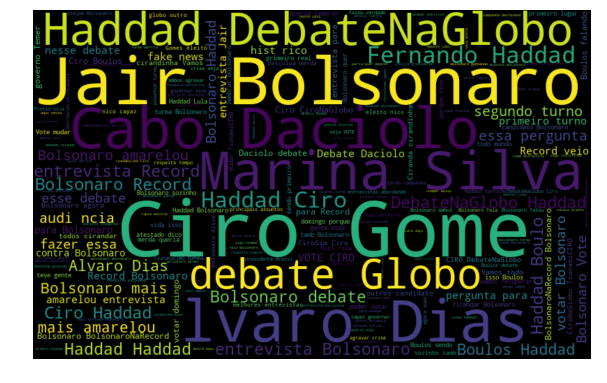

In [13]:
all_words = ' '.join([text for text in df['text']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Graphical visualization of the most frequent words

In [14]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df['text'])

In [15]:
word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
#word_count[:20]

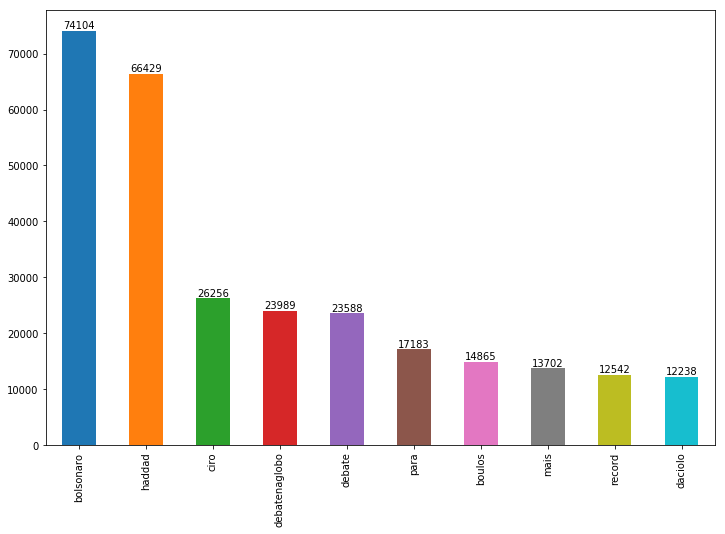

In [16]:
freq_series = pd.Series.from_array(word_count['count'][:10])

x_labels = word_count['word'][:10]

plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(x_labels)

rects = ax.patches
labels = word_count['count'][:10]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

## Preparation of data for the training set

In [17]:
def clean_string(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    cleanr = re.compile('<.*?>')

    string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')


    return string.strip().lower()

In [18]:
def prepare_data(data):
    data = data[['text_pt','sentiment']]

    data['text'] = data['text_pt'].apply(lambda x: x.lower())
    data['text'] = data['text_pt'].apply(lambda x: clean_string(x))
    data['text'] = data['text_pt'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    
    stop_words = set(stopwords.words('portuguese'))
    text = []
    for row in data['text'].values:
        word_list = text_to_word_sequence(row)
        no_stop_words = [i for i in word_list if not i in stop_words]
        no_stop_words = " ".join(no_stop_words)
        text.append(no_stop_words)
        
    tokenizer = Tokenizer(num_words=max_fatures, split=' ')

    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)  
    X = pad_sequences(X, maxlen=max_sequence_length)
    
    word_index = tokenizer.word_index
    Y = pd.get_dummies(data['sentiment']).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

    return X_train, X_test, Y_train, Y_test, word_index, tokenizer
    
    

In [19]:
data = pd.read_csv("../input/imdb-reviews/imdb-reviews-pt.csv", delimiter=',')

In [20]:
data.head(5)

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [21]:
X_train, X_test, Y_train, Y_test, word_index, tokenizer = prepare_data(data)

In [22]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(39567, 300) (39567, 2)
(9892, 300) (9892, 2)


In [23]:
def load_pre_trained(word_index, num_words, word_embedding_dim):
    embeddings_index = {}
    f = open(os.path.join('../input/glove-s50/', 'glove_s{}.txt'.format(word_embedding_dim)), encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('%s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((num_words, word_embedding_dim))
    for word, i in word_index.items():
        if i >= max_fatures:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [24]:
def model():
    if pre_trained_wv is True:
        num_words = min(max_fatures, len(word_index) + 1)
        weights_embedding_matrix = load_pre_trained_wv(word_index, num_words, word_embedding_dim)
        input_shape = (max_sequence_length,)
        model_input = Input(shape=input_shape, name="input", dtype='int32')    
        embedding = Embedding(num_words, word_embedding_dim, input_length=max_sequence_length, name="embedding", weights=[weights_embedding_matrix], trainable=False)(model_input)
        if bilstm is True:
            lstm = Bidirectional(LSTM(word_embedding_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm"))(embedding)
        else:
            lstm = LSTM(word_embedding_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm")(embedding)
    else:
        input_shape = (max_sequence_length,)
        model_input = Input(shape=input_shape, name="input", dtype='int32')    
        embedding = Embedding(max_fatures, embed_dim, input_length=max_sequence_length, name="embedding")(model_input)
        
        if bilstm is True:
            lstm = Bidirectional(LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm"))(embedding)
        else:
            lstm = LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm")(embedding)
    
    model_output = Dense(2, activation='softmax', name="softmax")(lstm)
    model = Model(inputs=model_input, outputs=model_output)
    
    return model

## Training the LSTM model with the training and validation sets

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
softmax (Dense)              (None, 2)                 258       
Total params: 771,842
Trainable params: 771,842
Non-trainable params: 0
_________________________________________________________________
None
Train on 39567 samples, validate on 9892 samples
Epoch 1/5
39567/39567 [==============================] - 947s 24ms/step - loss: 0.3983 - acc: 0.8234 - val_loss: 0.3171 - val_acc: 0.8716
Epoch 2/5
39567/39567 [==============================] - 960s 24ms/step - lo

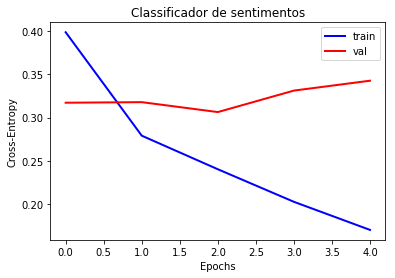

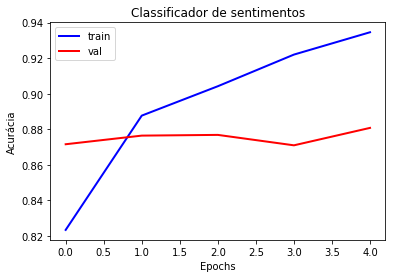

Acc: 88.08%


In [25]:
model = model()
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

if not os.path.exists('./{}'.format(filename) ):
    hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)
    model.save_weights(filename)    
    
    # Plot
    plt.figure()
    plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title('Classificador de sentimentos')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy')
    plt.legend(loc='upper right')
    plt.show()

    plt.figure()
    plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
    plt.title('Classificador de sentimentos')
    plt.xlabel('Epochs')
    plt.ylabel('Acurácia')
    plt.legend(loc='upper left')
    plt.show()

else:
    model.load_weights('./{}'.format(filename) )

scores = model.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print("Acc: %.2f%%" % (scores[1]*100))

## The opteve 88.08 accuracy model with the training and validation set.

## Now the forecast is made with 5000 thousand tweets using the previously trained LSTM model.

In [33]:
i = 0
for twitte in df['text']:
    if i == 5000:
        break
    sentence = clean_string(twitte)

    new_text = [sentence]
    new_text = tokenizer.texts_to_sequences(new_text)

    new_text = pad_sequences(new_text, maxlen=max_sequence_length, dtype='int32', value=0)

    sentiment = model.predict(new_text,batch_size=1,verbose = 2)[0]

    if(np.argmax(sentiment) == 0):
        pred_proba = "%.2f%%" % (sentiment[0]*100)
        df['sentiment'][i] = 'negativo'
        df['percentage'][i] = pred_proba
    elif (np.argmax(sentiment) == 1):
        pred_proba = "%.2f%%" % (sentiment[1]*100)
        df['sentiment'][i] = 'positivo'
        df['percentage'][i] = pred_proba
        
    i = i + 1

In [34]:
df.head(10)

,Unnamed: 0,created_at,text,tokenized_tweet,sentiment,percentage
0,0,Fri Oct 05 01:11:00 +0000 2018,deve doer para Veja escrever isso kkkkk QzIYoQEW,"[deve, doer, para, Veja, escrever, isso, kkkkk...",positivo,76.95%
1,1,Fri Oct 05 01:11:00 +0000 2018,LIVE agora Compartilhe IMcSPKXB,"[LIVE, agora, Compartilhe, https, IMcSPKXB]",negativo,71.47%
2,2,Fri Oct 05 01:11:00 +0000 2018,Bolsonaro PlayStation PlayStation Bolsonaro #B...,"[Bolsonaro, PlayStation, PlayStation, Bolsonar...",positivo,53.79%
3,3,Fri Oct 05 01:11:00 +0000 2018,Voto anti aparece beneficia Jair Bolsonaro pos...,"[Voto, anti, aparece, beneficia, Jair, Bolsona...",positivo,92.36%
4,4,Fri Oct 05 01:11:00 +0000 2018,Nazista quem ataca Israel chegando ponto queim...,"[Nazista, quem, ataca, Israel, chegando, ponto...",negativo,89.10%
5,5,Fri Oct 05 01:11:00 +0000 2018,jornalista record poderia pelo menos tico Quem...,"[jornalista, record, poderia, pelo, menos, tic...",negativo,50.85%
6,6,Fri Oct 05 01:11:00 +0000 2018,anos garantimos crescimento distribui renda au...,"[anos, garantimos, crescimento, distribui, ren...",negativo,70.18%
7,7,Fri Oct 05 01:11:00 +0000 2018,Bolsonaro candidatar Bolsonaro existe internet...,"[Bolsonaro, candidatar, Bolsonaro, existe, int...",positivo,60.00%
8,8,Fri Oct 05 01:11:00 +0000 2018,pessoas risada quando Cabo Daciolo monte pedir...,"[pessoas, risada, quando, Cabo, Daciolo, monte...",negativo,94.93%
9,9,Fri Oct 05 01:11:00 +0000 2018,Ciro come como estagi portal sensacionalista #...,"[Ciro, come, como, estagi, portal, sensacional...",positivo,91.60%


In [41]:
df[:5000].to_csv('../input/prev-tweets.csv')

In [42]:
prev_tweets = pd.read_csv('../input/prev-tweets.csv')

## The following is graphically shown the amount of tweets with negative feeling and positive feeling.

In [45]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(prev_tweets['sentiment'])

In [46]:
word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)

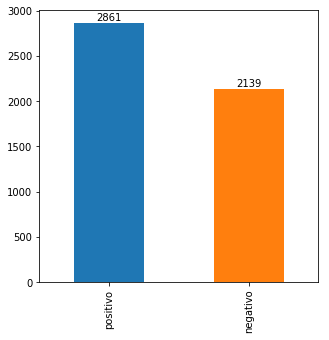

In [52]:
freq_series = pd.Series.from_array(word_count['count'][:2])

x_labels = word_count['word'][:2]

plt.figure(figsize=(5, 5))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(x_labels)

rects = ax.patches
labels = word_count['count'][:2]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

# Conclusion
### The tweets used in this experiment were captured on the day of a debate among Brazil's prestige candidates. 180,000 thousand tweets were captured, but for reasons of low computational resources, the model only forecast about 5,000 thousand tweets. As a result it was possible to observe that tweets with positive feeling were the majority.